In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
from os.path import join

sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))
from early_stopping import *

In [3]:
#export
class LearningRateSearch(Callback):
    def __init__(self, max_iter=1000, min_lr=1e-4, max_lr=1):
        self.max_iter = max_iter
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.best_loss = float('inf')
        
    def before_batch(self): 
        if not self.model.training: return
        position = self.iters_count / self.iters
        learning_rate = self.min_lr * (self.max_lr/self.min_lr)**position
        self.optimizer.hyper_params['learning_rate'] = learning_rate
            
    def after_step(self):
        if self.iters_count >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        self.best_loss = min(self.best_loss, self.loss)

In [4]:
num_hidden = 50
batch_size = 64
num_epochs = 20
learning_rate = 0.1

data_bunch = get_data_bunch(*get_mnist_data(), batch_size)
model, optimizer = get_model(data_bunch, learning_rate, num_hidden)
loss_fn = CrossEntropy()
learner = Learner(model, optimizer, loss_fn, data_bunch)

runner = Runner(learner, [LearningRateSearch(), Recorder(['learning_rate'])])
print(runner)

(DataBunch) 
	(DataLoader) 
		(Dataset) x: (50000, 784), y: (50000,)
		(Sampler) total: 50000, batch_size: 64, shuffle: True
	(DataLoader) 
		(Dataset) x: (10000, 784), y: (10000,)
		(Sampler) total: 10000, batch_size: 128, shuffle: False
(Sequential)
	(Layer1) Linear(784, 50)
	(Layer2) ReLU()
	(Layer3) Linear(50, 10)
(CrossEntropy)
(Optimizer) num_params: 4, hyper_params: ['learning_rate']
(Callbacks) TrainEval LearningRateSearch Recorder


In [5]:
runner.fit(1000)

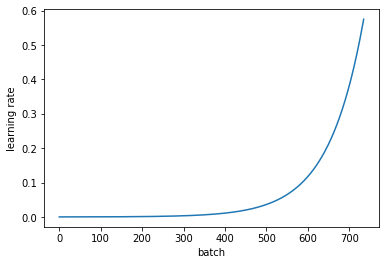

In [6]:
runner.callbacks[2].plot_parameter('learning_rate')

In [7]:
#export
def plot_lr_loss(LearningRateSearch):
    losses = [l.item() for l in LearningRateSearch.losses]
    learning_rates = LearningRateSearch.parameters['learning_rate']
    plt.xscale('log')
    plt.plot(learning_rates[:len(losses)], losses[:len(losses)])
    plt.xlabel('learning rate')
    plt.ylabel('loss')

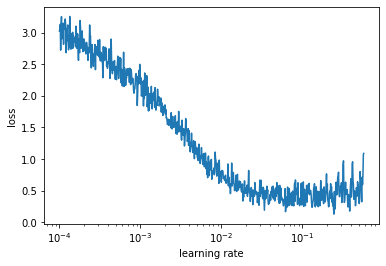

In [8]:
plot_lr_loss(runner.callbacks[2])